# Inversiones 1D: Modulos TE y TM

Inversión de datos MT para los sondeos realizados en el área geotérmica del volcán Cerro Machín 

## Liberías

In [1]:
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
from ipywidgets import interact, widgets
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
## mtpy 1.1.5
## mtpy-v2 2.0.7
from pathlib import Path

## Funciones

In [4]:
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

def metrics(true_values, predicted_values):
    mse = mean_squared_error(dobs, dpred)
    mae = mean_absolute_error(true_values, predicted_values)
    correlation, _ = pearsonr(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    mre = np.mean(np.abs((true_values - predicted_values) / true_values))
    
    return {
        "MSE": mse,
        "MAE": mae,
        "Pearson Correlation": correlation,
        "R²": r2,
        "MRE": mre,
    }

## Visualización de datos con MTpy_v2

In [5]:
mc = MTCollection()
mc.open_collection(Path("Erick.h5"))

In [6]:
mc.master_dataframe.head()

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,GEO,MC,6.964108,-73.049004,965.97,GEO,none,True,True,False,0.000167,1.1,<HDF5 object reference>,<HDF5 object reference>


24:11:26T16:56:09 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID GEO. Suggest setting survey, otherwise returning the TF from survey MC.


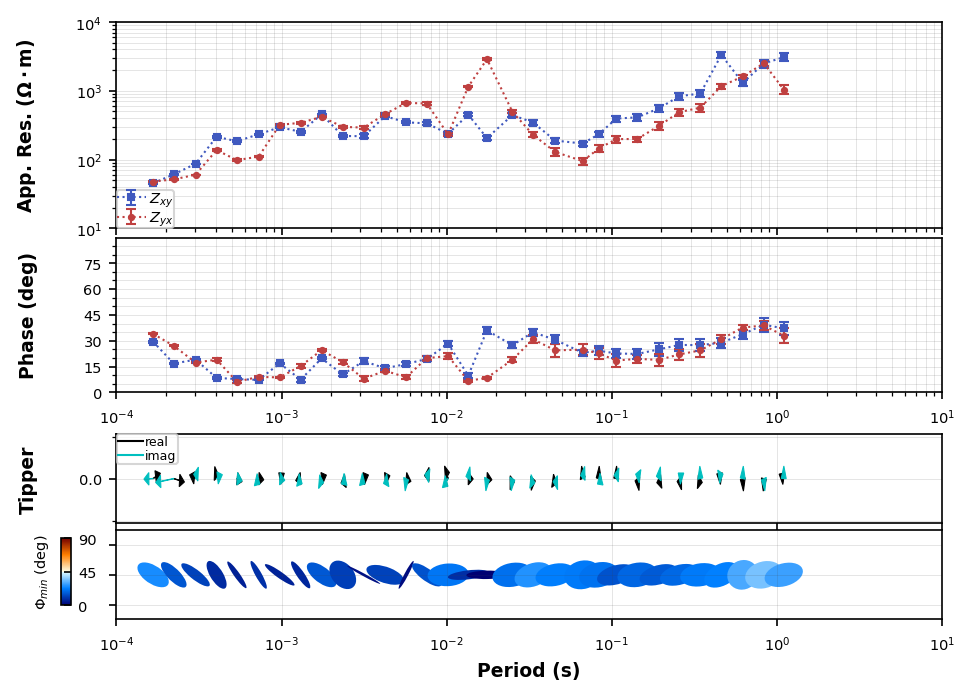

In [7]:
try: 
    mc.plot_mt_response("GEO")
except:
    pass

In [8]:
%%time
mt_data = mc.to_mt_data()

CPU times: total: 78.1 ms
Wall time: 396 ms


In [9]:
interp_mt_data = mt_data

In [109]:
# Se escoge un rango de periodos objetivo (ejemplo, 0.005 a 9 [s]), con un total de 20 datos
interp_periods = np.logspace(np.log10(0.0001), np.log10(0.0005), 50)
# Interpolación de los datos de cada estación 
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

In [110]:
from pyproj import CRS
utm_crs = CRS.from_epsg(32618)  # Cambia al EPSG correcto para tu caso
interp_mt_data.utm_crs = utm_crs

TypeError: Got both 'size' and 'fontsize', which are aliases of one another

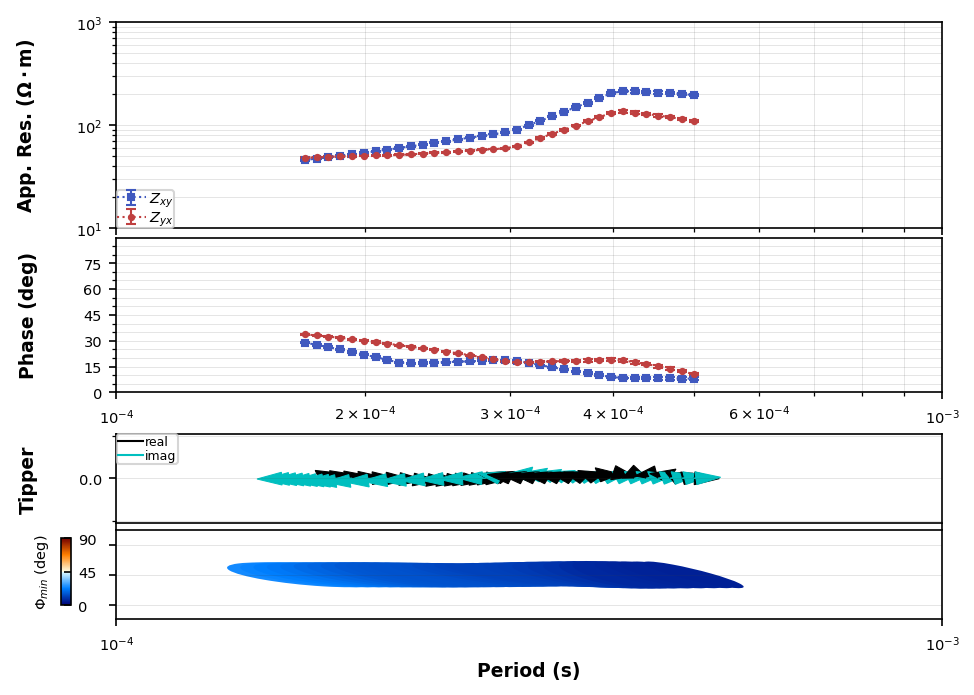

In [111]:
interp_mt_data.plot_mt_response(station_key="MC.GEO")

In [92]:
res_array = interp_mt_data.get_station(station_key=station).Z.resistivity
phase_array = interp_mt_data.get_station(station_key=station).Z.phase
freq = interp_mt_data.get_station(station_key=station).Z.frequency

In [ ]:
z_obj2.set_res_phase(res_array=res_array, phase_array=phase_array, freq=freq)

Resetting z and z_err


In [22]:
pt_obj = MTpt.PhaseTensor(z_object=z_obj2,
                          freq=z_obj2.freq)

	Warning - could not digest provided Z-Object


In [53]:
def z2pt_copy(z_array, z_err_array=None):
    pt_array = np.zeros((z_array.shape[0], 2, 2))

    for idx_f in range(len(z_array)):

        realz = np.real(z_array[idx_f])
        imagz = np.imag(z_array[idx_f])

        detreal = np.linalg.det(realz)

        pt_array[idx_f, 0, 0] = realz[1, 1] * imagz[0, 0] - realz[0, 1] * imagz[1, 0]
        pt_array[idx_f, 0, 1] = realz[1, 1] * imagz[0, 1] - realz[0, 1] * imagz[1, 1]
        pt_array[idx_f, 1, 0] = realz[0, 0] * imagz[1, 0] - realz[1, 0] * imagz[0, 0]
        pt_array[idx_f, 1, 1] = realz[0, 0] * imagz[1, 1] - realz[1, 0] * imagz[0, 1]

        pt_array /= detreal
        return pt_array

In [72]:
pt_array = np.zeros((z_obj2.z.shape[0], 2, 2))

for idx_f in range(len(z_obj2.z)):

    realz = np.real(z_obj2.z[idx_f])
    imagz = np.imag(z_obj2.z[idx_f])

    detreal = np.linalg.det(realz)

    pt_array[idx_f, 0, 0] = realz[1, 1] * imagz[0, 0] - realz[0, 1] * imagz[1, 0]
    pt_array[idx_f, 0, 1] = realz[1, 1] * imagz[0, 1] - realz[0, 1] * imagz[1, 1]
    pt_array[idx_f, 1, 0] = realz[0, 0] * imagz[1, 0] - realz[1, 0] * imagz[0, 0]
    pt_array[idx_f, 1, 1] = realz[0, 0] * imagz[1, 1] - realz[1, 0] * imagz[0, 1]

    pt_array /= detreal

In [ ]:
pt_obj = MTpt.PhaseTensor(pt_array=pt_array,
                          freq=z_obj2.freq)

In [87]:
try:
    print(dimensionality(
        z_object = z_obj2,
        skew_threshold=3,
        eccentricity_threshold=0.1,
        
        #freq_array = z_obj.frequency,
        #z_array=mt_obj.Z
    ))
except TypeError as e:
    print(f"Error: {e}")

	Warning - could not digest provided Z-Object
Error: object of type 'NoneType' has no len()


In [ ]:
dim = dimensionality(
    pt_object = pt_obj,
    skew_threshold=3,
    eccentricity_threshold=0.1,
)

In [90]:
print(dim)
len(dim)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 3 3 3
 3 3 3 3 2 2 3 3 3 2 3 3 3]


50

In [74]:
interp_mt_data.get_station(station_key=station).frequency

array([5623.4132519 , 5108.96977451, 4641.58883361, 4216.96503429,
       3831.18684956, 3480.70058843, 3162.27766017, 2872.98483335,
       2610.15721568, 2371.37370566, 2154.43469003, 1957.34178149,
       1778.27941004, 1615.59809844, 1467.79926762, 1333.52143216,
       1211.52765863, 1100.69417125, 1000.        ])

In [30]:
try:
    print(dimensionality(
        z_object = z_obj2,
        skew_threshold=3,
        eccentricity_threshold=0.1,
        
        #freq_array = z_obj.frequency,
        #z_array=mt_obj.Z
    ))
except TypeError as e:
    print(f"Error: {e}")

	Warning - could not digest provided Z-Object
Error: object of type 'NoneType' has no len()


In [112]:
station="MC.GEO"
data_xy_station=[interp_mt_data.get_station(station_key=station).Z.frequency,
              interp_mt_data.get_station(station_key=station).Z.res_xy,
              interp_mt_data.get_station(station_key=station).Z.phase_xy]
data_yx_station=[interp_mt_data.get_station(station_key=station).Z.frequency,
                interp_mt_data.get_station(station_key=station).Z.res_yx,
                interp_mt_data.get_station(station_key=station).Z.phase_yx]
data_station=[interp_mt_data.get_station(station_key=station).Z.frequency,
                interp_mt_data.get_station(station_key=station).Z.res_det,
                interp_mt_data.get_station(station_key=station).Z.phase_det]

In [113]:
print(1/interp_mt_data.get_station(station_key=station).Z.frequency)

[0.00016914 0.00017478 0.00018062 0.00018665 0.00019288 0.00019932
 0.00020598 0.00021286 0.00021996 0.00022731 0.0002349  0.00024274
 0.00025085 0.00025922 0.00026788 0.00027683 0.00028607 0.00029562
 0.00030549 0.00031569 0.00032623 0.00033713 0.00034838 0.00036002
 0.00037204 0.00038446 0.0003973  0.00041056 0.00042427 0.00043844
 0.00045308 0.00046821 0.00048384 0.0005    ]


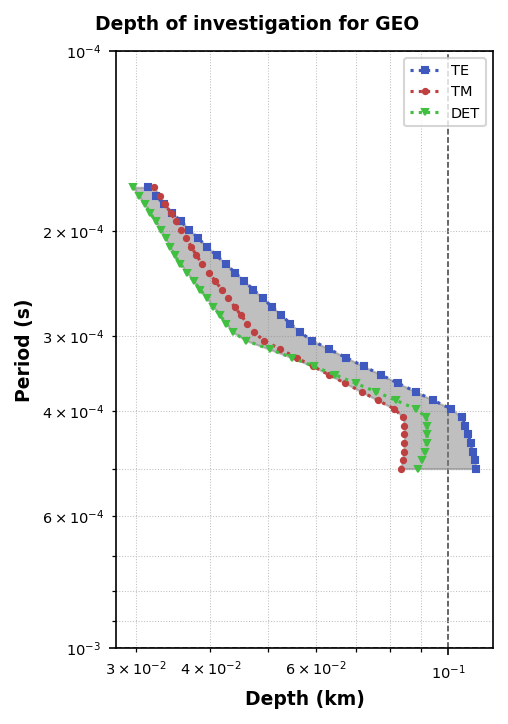

Plotting PlotPenetrationDepth1D

In [114]:
interp_mt_data.plot_penetration_depth_1d(station_key=station)

In [115]:
depth_array = interp_mt_data.get_station(station_key=station).Z.estimate_depth_of_investigation()
period = []
TE = []
TM = []
DET = []
for i in range(len(depth_array)):
    period.append(depth_array[i][0])
    TE.append(depth_array[i][1])
    TM.append(depth_array[i][2])
    DET.append(depth_array[i][3])
print(f"Estación {station}: Modulo TE la profundidad máx de investigación es:{DET[-1]:.2f}","\n",
      #f"Estación {station}: Modulo TM la profundidad máx de investigación es:{TM[-1]:.2f}"
      )

Estación MC.GEO: Modulo TE la profundidad máx de investigación es:89.00 



In [118]:
# Correr inversión de MT
dz = 1
n_layer = 17
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

print("El espesor total del modelo será:", layer_thicknesses_inv.sum(), "metros")

El espesor total del modelo será: 87.44212944751817 metros


In [119]:
# Correr inversión de MT
frequencies = data_xy_station[0]

def run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=20,
    maxIterCG=30,
    alpha_s=1e-10,  #Parametros de la regularización
    alpha_z=1,       #/// de la reg
    beta0_ratio=0.1,
    coolingFactor=2,  #Parametros opti
    coolingRate=1,    #/// opti
    chi_factor=1
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(
        mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref,
        mapping=maps.IdentityMap(mesh=mesh_inv)
    )

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Definir el problema inverso
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################

    # Definir Directivas de Inversión
    # ---------------------------
    #
    # Aquí definimos las directivas que se llevarán a cabo durante la inversión. Esto
    # incluye el programa de enfriamiento para el parámetro de intercambio (beta), los
    # criterios de detención para la inversión y el guardado de los resultados de la inversión
    # en cada iteración.
    #

    # Definiendo un valor inicial para el parámetro de intercambio (beta) entre el desajuste
    # de datos y la regularización.

    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Establece la tasa de reducción del parámetro de intercambio (beta) cada vez que
    # se resuelve el problema inverso. Y establece el número de iteraciones de Gauss-Newton
    # para cada valor del parámetro de intercambio.

    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Estableciendo un criterio de detención para la inversión.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)

    # Las directivas se definen como una lista
    directives_list = [
        starting_beta,
        beta_schedule,
        target_misfit,
        save_dictionary
    ]

    #####################################################################
    # Ejecutando la Inversión
    # ---------------------
    #
    # Para definir el objeto de inversión, necesitamos definir el problema de inversión y
    # el conjunto de directivas. Luego podemos ejecutar la inversión.
    #

    # Aquí combinamos el problema inverso y el conjunto de directivas

    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Correr la inversión
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict



In [120]:
print(layer_thicknesses_inv.sum())

87.44212944751817


In [121]:
#app_rho = data_xy_station[1]
#phase = data_xy_station[2]
#app_rho = data_yx_station[1]
#phase = data_yx_station[2]+180
app_rho = data_station[1]
phase = data_station[2]
std = np.c_[abs(app_rho)*0.03, np.ones(len(phase))*2].flatten()
noise = np.c_[np.random.randn(app_rho.size)*0.03*abs(app_rho), np.random.randn(app_rho.size)*2].flatten()
dobs = np.c_[app_rho, phase].flatten()
relative_error_rho= .03
floor_phase= .5
standard_deviation = np.c_[abs(app_rho)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
rho_0 = 100.
rho_ref = 100.

output_dict ={}
recovered_model, output_dict = run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-6,   
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.48e+03  5.06e+04  0.00e+00  5.06e+04    2.72e+04      0              


c:\Programas\anaconda3\envs\simpeg0170\Lib\site-packages\SimPEG\optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  1.74e+03  5.59e+03  1.99e-01  5.94e+03    6.01e+03      0              
   2  8.71e+02  2.53e+03  3.47e-01  2.84e+03    3.80e+03      0   Skip BFGS  
   3  4.36e+02  1.81e+03  4.78e-01  2.02e+03    9.45e+02      0   Skip BFGS  
   4  2.18e+02  1.70e+03  6.88e-01  1.85e+03    9.88e+02      0   Skip BFGS  
   5  1.09e+02  1.66e+03  8.12e-01  1.75e+03    8.87e+02      1   Skip BFGS  
   6  5.44e+01  1.64e+03  9.59e-01  1.69e+03    1.05e+03      2   Skip BFGS  
   7  2.72e+01  1.63e+03  1.09e+00  1.66e+03    1.21e+03      3   Skip BFGS  
   8  1.36e+01  1.62e+03  1.21e+00  1.64e+03    1.35e+03      4   Skip BFGS  
   9  6.81e+00  1.61e+03  1.29e+00  1.62e+03    1.45e+03      5   Skip BFGS  
  10  3.40e+00  1.61e+03  1.36e+00  1.62e+03    1.52e+03      6   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.9706e+00 <= tolF*(1+|f0|) = 5.0593e+03
1 : |xc-x_last| = 3.6122e-01 <= tolX*(1+|x0|) = 1.9988e+00
0 : |proj(x-g)-x|    = 1.5170e+03 <= tolG     

In [122]:
target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=10, description='iteration', max=10, min=1), RadioButtons(description='s…

In [123]:
def calculate_error(dobs, dpred):
    error = np.abs(dobs - dpred) / np.abs(dobs) * 100
    error.mean()
    return error
def plot_inverted_model_and_data(iteration):
    dpred = output_dict[iteration]['dpred']
    m = output_dict[iteration]['m']
    error = calculate_error(dobs, dpred)
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
    )
    # ax0.legend()
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_ylabel("Profundidad (m)")
    #ax0.set_xlim(1, 10000)
    # ax0.set_xlim(1, 1e4)
    ax0.set_xlim(10,10000)
    #ax0.set_ylim(25,0)


    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-AppRho.')
    ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-AppRho.')

    ax_1 = ax.twinx()
    ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
    ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
    ax.set_xlabel("Periodo (s)")
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Resistividad Aparente ($\Omega$m)")
    ax_1.set_ylabel("Fase ($\degree$)")
    # ax.legend(bbox_to_anchor=(1.1,1))
    ax.legend(loc=2)
    ax_1.legend(loc=1)
    ax.set_ylim(1, 10000)
    ax_1.set_ylim(0, 90)    
    ax0.set_xlim(0.001, 10000)
    ax.text(0.05, 0.15, f'Error Relativo: {error.mean():.2f}%', transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.show()
interact(
    plot_inverted_model_and_data, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration)
)

interactive(children=(IntSlider(value=10, description='iteration', max=10, min=1), Output()), _dom_classes=('w…

<function __main__.plot_inverted_model_and_data(iteration)>

In [51]:
iteration=10
m = output_dict[iteration]['m']
Espesores=layer_thicknesses_inv[::-1]
Espesores=np.insert(Espesores,0,0)
Topes=np.cumsum(Espesores)
Resistividad=(1./(np.exp(m)))[::-1]

In [66]:
Topes=np.cumsum(Espesores)
Topes

array([   0.        ,   19.        ,   41.8       ,   69.16      ,
        101.992     ,  141.3904    ,  188.66848   ,  245.402176  ,
        313.4826112 ,  395.17913344,  493.21496013,  610.85795215,
        752.02954258,  921.4354511 , 1124.72254132, 1368.66704959,
       1661.4004595 , 2012.6805514 , 2434.21666168, 2940.05999402,
       3547.07199283, 4275.48639139, 5149.58366967])

In [70]:
print(Espesores.sum())

5149.583669668143


In [21]:
print(Resistividad)

[4.84781119e+01 5.14929984e+01 5.69822164e+01 6.39071017e+01
 6.84932684e+01 6.41701240e+01 4.59460632e+01 2.04635609e+01
 4.86098343e+00 3.48243302e+00 8.15487509e+00 9.09194297e+00
 4.31909414e+00 2.55218731e+00 4.26309403e+00 7.86913100e+00
 1.03760561e+01 7.13963481e+00 1.26270213e+00 1.65860021e-03
 1.71889798e-03 1.75950519e-03]


In [22]:
Valor=Resistividad[-4]
#Resistividad
Valor


1.2627021316979117

In [23]:
Resistividad[-3:]=Valor

In [24]:
Resistividad

array([48.4781119 , 51.49299837, 56.98221635, 63.90710168, 68.49326838,
       64.17012397, 45.94606318, 20.46356086,  4.86098343,  3.48243302,
        8.15487509,  9.09194297,  4.31909414,  2.55218731,  4.26309403,
        7.869131  , 10.37605608,  7.13963481,  1.26270213,  1.26270213,
        1.26270213,  1.26270213])

In [52]:
segmentos = []
nuevas_resistividades = []

# Definir el crecimiento cuadrático en segmentos, empezando con 2 y aumentando al cuadrado
for i in range(len(Topes) - 1):
    tope_inferior = Topes[i]
    tope_superior = Topes[i + 1]
    
    # Crecimiento cuadrático: cuadrado del índice de la capa más 2
    n_segmentos = 2 + (i ** 2) // 5  # Ajustar el divisor para controlar el crecimiento
    
    # Espacio entre el tope inferior y el superior
    espacio = tope_superior - tope_inferior
    espesor_segmento = espacio / n_segmentos
    
    # Añadir los nuevos topes
    for j in range(1, n_segmentos + 1):
        nuevo_tope = tope_inferior + j * espesor_segmento
        segmentos.append(nuevo_tope)
    
    # Añadir la resistividad correspondiente a cada segmento
    for _ in range(n_segmentos):
        nuevas_resistividades.append((1./(np.exp(m)))[::-1][i])

# Convertir las listas a arrays
segmentos = np.array(segmentos)
nuevas_resistividades = np.array(nuevas_resistividades)
nuevas_resistividades[-1]=Resistividad[-1]
# Resultado
print("Segmentos (Crecimiento Cuadrático):", segmentos)
print("Nuevas Resistividades:", nuevas_resistividades)

Segmentos (Crecimiento Cuadrático): [  13.5          27.           43.2          59.4          78.84
   98.28        113.832       129.384       144.936       156.13344
  167.33088     178.52832     189.72576     200.9232      210.52100571
  220.11881143  229.71661714  239.31442286  248.91222857  258.51003429
  268.10784     277.065792    286.023744    294.981696    303.939648
  312.8976      321.855552    330.813504    339.771456    348.729408
  357.52448815  366.31956829  375.11464844  383.90972858  392.70480873
  401.49988887  410.29496902  419.09004916  427.88512931  436.68020945
  445.4752896   453.76779374  462.06029787  470.35280201  478.64530615
  486.93781029  495.23031442  503.52281856  511.8153227   520.10782683
  528.40033097  536.69283511  544.98533925  553.27784338  561.57034752
  569.31001805  577.04968858  584.7893591   592.52902963  600.26870016
  608.00837069  615.74804122  623.48771174  631.22738227  638.9670528
  646.70672333  654.44639386  662.18606438  669.9257349

In [53]:
df = pd.DataFrame({
    'Z (Espesores)': segmentos,
    'Resistividad (Ohm*m)': nuevas_resistividades
})

# Exportar a un archivo Excel
df.to_excel( f'{station}.xlsx', index=False)


In [898]:
mc.close_collection()

TypeError: Cannot cast array data from dtype([('survey', 'S30'), ('station', 'S30'), ('run', 'S20'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('component', 'S20'), ('start', 'S36'), ('end', 'S36'), ('n_samples', '<i8'), ('sample_rate', '<f8'), ('measurement_type', 'S30'), ('azimuth', '<f8'), ('tilt', '<f8'), ('units', 'S60'), ('has_data', '?'), ('hdf5_reference', 'O'), ('run_hdf5_reference', 'O'), ('station_hdf5_reference', 'O')]) to dtype([('survey', 'S30'), ('station', 'S30'), ('run', 'S20'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('component', 'S20'), ('start', 'S36'), ('end', 'S36'), ('n_samples', '<i8'), ('sample_rate', '<f8'), ('measurement_type', 'S30'), ('azimuth', '<f8'), ('tilt', '<f8'), ('units', 'S60'), ('hdf5_reference', 'O'), ('run_hdf5_reference', 'O'), ('station_hdf5_reference', 'O')]) according to the rule 'unsafe'